In [1]:
from ase.io import read
from ase import units
import numpy as np
import znh5md
import matplotlib.pyplot as plt

In [67]:
k_95 = [0.0, 12.71, 4.303, 3.182, 2.776, 2.571, 2.447, 2.365, 2.306, 2.262, 2.228]

In [6]:
def analyse(traj, T, prefix, rho_exp):
    data = znh5md.ASEH5MD(traj)
    atoms = data.get_atoms_list()

    total_mass = sum(atoms[0].get_masses())

    volumes = []
    for a in atoms:
        v= a.get_volume()
        volumes.append(v)

    volumes = np.array(volumes[:]) * 10**(-30)
    mv = np.mean(volumes) 
    d = total_mass * units._amu / mv / 1000
    densities = total_mass * units._amu / volumes / 1000

    davg = np.cumsum(densities)
    davg /= np.arange(1, len(davg)+1)
    fig, ax = plt.subplots(1,1)
    ax.plot(densities, label=r"$\rho$ instantaneous")
    ax.plot(davg, label=r"$\rho$ cumulative mean" + f" = {davg[-1]:.3f}")
    ax.set_ylim([0.4,1.3])
    ax.set_xlabel("time step x10")
    ax.set_ylabel(r"$\rho$ g/cm^3")
    ax.axhline(rho_exp/1000, c="black", label=f"exp = {rho_exp/1000:.3f}")
    ax.legend()
    ax.set_title(f"T={T} K, {prefix}")
    # plt.savefig(f"plots/density_{prefix}_{T}.png")

In [21]:
def get_density(trajs, slices):
    rho_sims = []
    rho_std_sims = []
    for ii, traj in enumerate(trajs):
        print(traj)
        data = znh5md.ASEH5MD(traj)
        atoms = data.get_atoms_list()

        total_mass = sum(atoms[0].get_masses())

        volumes = []
        for a in atoms:
            v= a.get_volume()
            volumes.append(v)

        volumes = np.array(volumes[slices[ii]]) * 10**(-30)
        mv = np.mean(volumes) 
        densities = total_mass * units._amu / volumes

        davg = np.cumsum(densities)
        davg /= np.arange(1, len(davg)+1)
        rho = davg[-1]
        rho_sims.append(rho)
        rho_std_sims.append(np.std(densities))
        # break
    
    return rho_sims, rho_std_sims    

In [63]:
traj = "nodes/ML17_density_models/ASEMD_5/trajectory.h5"
equil_slice = slice(0,-1)
M = 6


data = znh5md.ASEH5MD(traj)
atoms = data.get_atoms_list()[equil_slice]


total_mass = sum(atoms[0].get_masses())

all_volumes = [a.get_volume() for a in atoms]
volumes = np.array(all_volumes) * 10**(-30)
mv = total_mass * units._amu / np.mean(volumes) 
densities = total_mass * units._amu / volumes


(1180.9613180367608,
 [1172.4992025857205,
  1183.4031120172901,
  1181.9758336992195,
  1169.612724565546,
  1178.0037828480686,
  1200.7863573615643])

In [65]:
def block_average(atoms, M):
    n_data = len(atoms)
    interval_length = n_data // M
    total_mass = sum(atoms[0].get_masses())

    interval_means = []
    for m in range(M):
        interval_volumes = [a.get_volume() for a in atoms[m*interval_length: m*interval_length + interval_length]]
        interval_rho = total_mass * units._amu / (np.mean(interval_volumes) * 10**(-30)) / 1000
        interval_means.append(interval_rho)

    mean = np.mean(interval_means)
    std_mean = np.std(interval_means)
    return mean, std_mean

In [72]:
def determine_n_blocks(atoms):
    stds = []
    Ms = range(2,10)
    for m in Ms:
        print(m)
        mean, std_mean = block_average(atoms, m)
        stds.append(std_mean)
    fig, ax = plt.subplots(1,1, figsize=(12,6))
    ax.plot(Ms, stds)
    plt.show()

In [69]:
k = k_95[6-1]
mean, std_mean = block_average(atoms, 6)

print(f"{mean:.3f} +- {k*std_mean:.3f}")

1.181 +- 0.026


In [64]:
mean = np.mean(interval_means)
std_mean = np.std(interval_means)
mean, std_mean

(1181.0468355129012, 10.075753824109691)

## Various Models

In [26]:
trajs = [
    "nodes/ML17_density_models/ASEMD_1/trajectory.h5", # 
    "nodes/ML17_density_models/ASEMD_2/trajectory.h5", # 
    # "nodes/ML17_density_models/ASEMD_3/trajectory.h5", # 
    "nodes/ML17_density_models/ASEMD_4/trajectory.h5", # 
    "nodes/ML17_density_models/ASEMD_5/trajectory.h5", # 
    "nodes/ML17_density_models/ASEMD_6/trajectory.h5", # 
]

rho_exps = [
    1211,
    1211,
    # 1211,
    1211,
    1211,
    1211,
]
temps = [
    283,
    283,
    # 283,
    283,
    283,
    283,
]

nodes/ML17_density_models/ASEMD_1/trajectory.h5
nodes/ML17_density_models/ASEMD_2/trajectory.h5
nodes/ML17_density_models/ASEMD_4/trajectory.h5
nodes/ML17_density_models/ASEMD_5/trajectory.h5
nodes/ML17_density_models/ASEMD_6/trajectory.h5


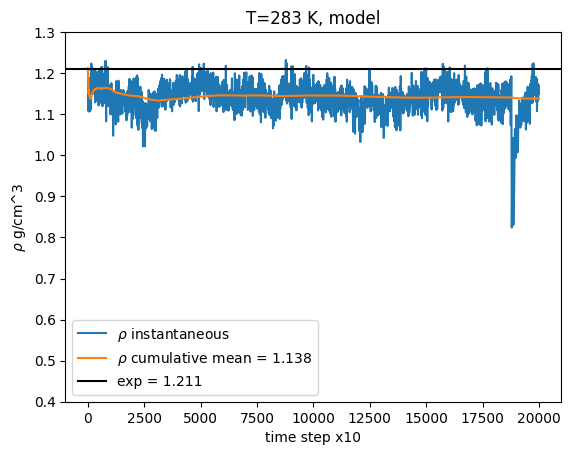

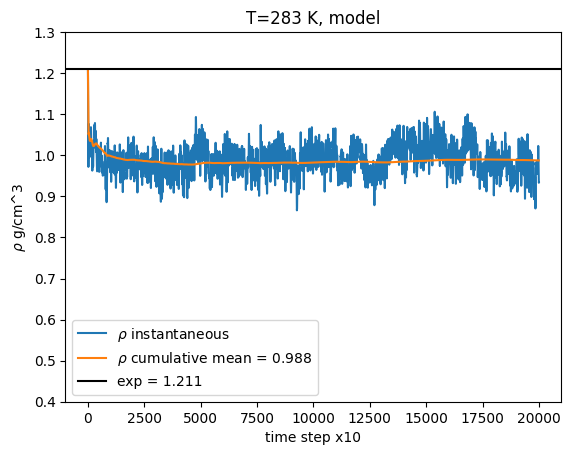

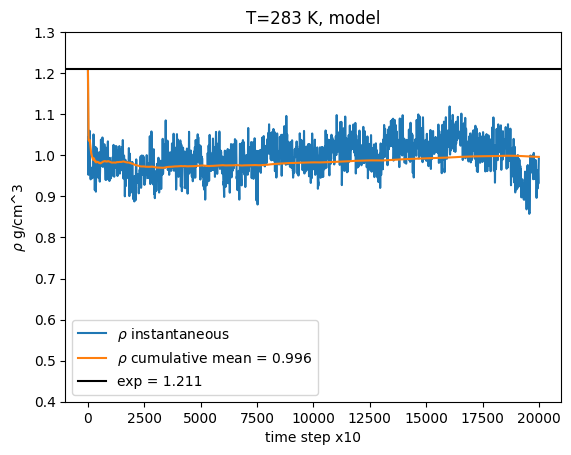

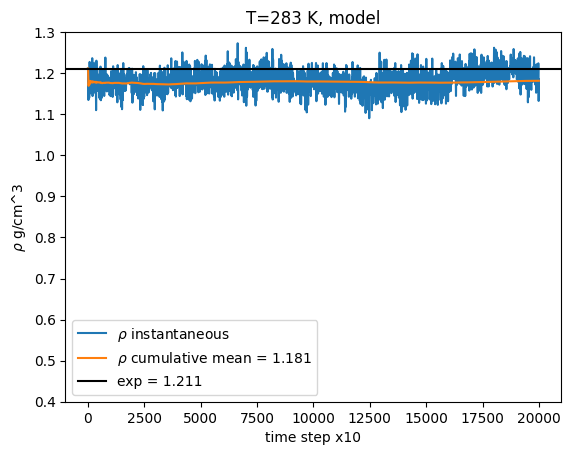

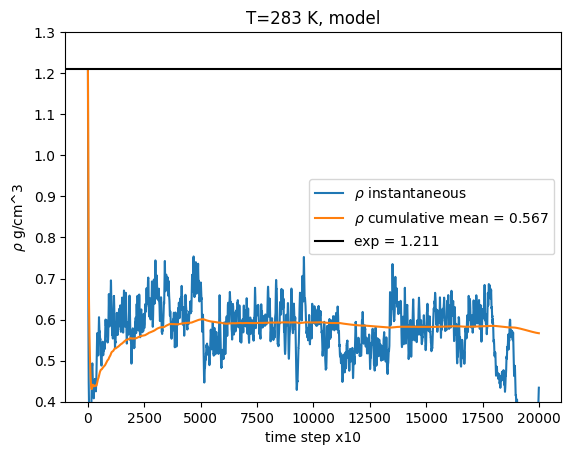

In [27]:
prefix = ["model" for t in temps]
for pref, T, traj, rho in zip(prefix, temps, trajs, rho_exps):
    print(traj)
    analyse(traj, T, pref, rho)

In [70]:
slices = [slice(6000,-1), slice(3000,-1), slice(2500,-1), slice(100, -1), slice(5000, 17500)]
    
# rho_models, rho_std_models = get_density(trajs, slices)

2
3
4
5
6
7
8
9


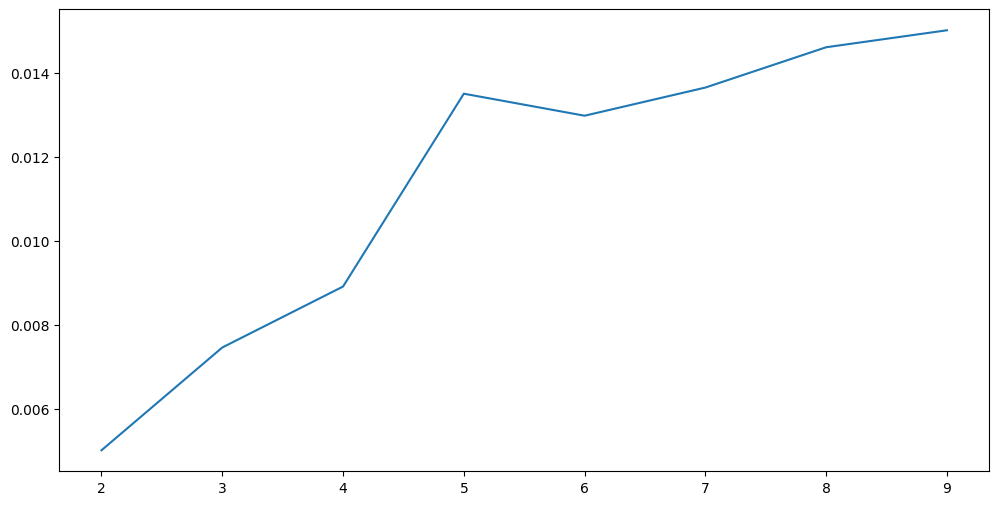

2
3
4
5
6
7
8
9


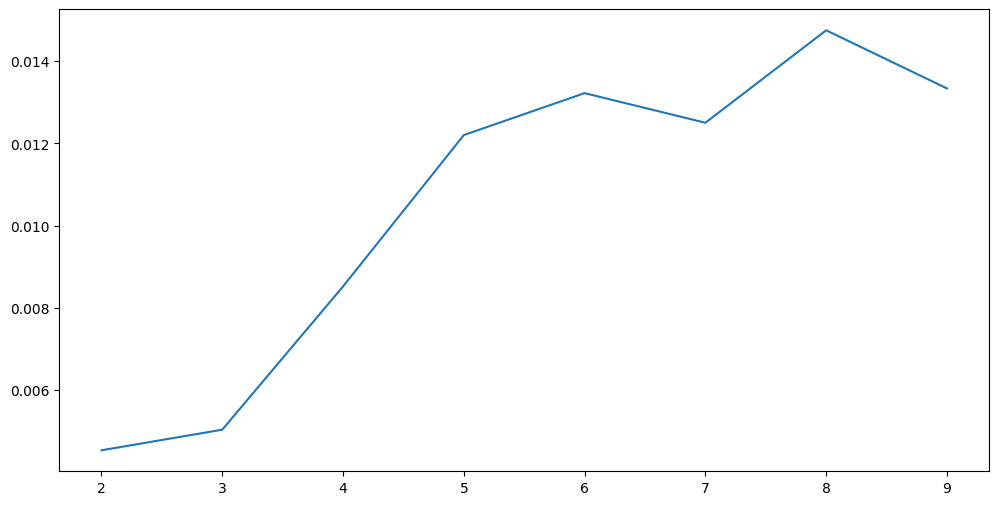

2
3
4
5
6
7
8
9


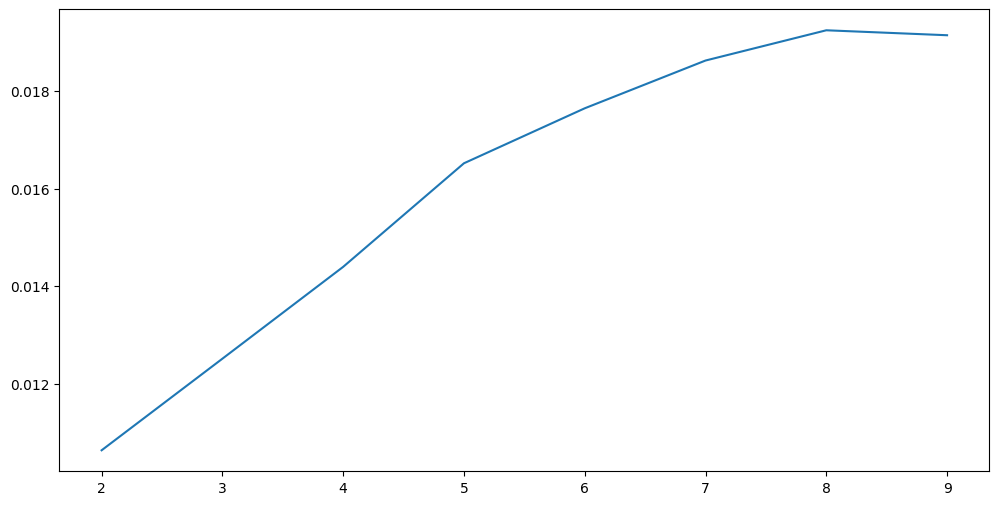

2
3
4
5
6
7
8
9


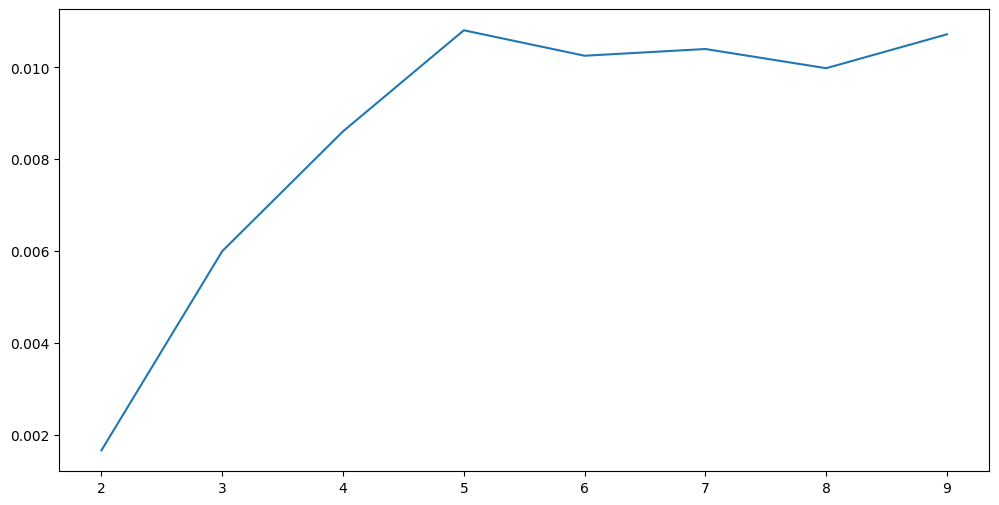

2
3
4
5
6
7
8
9


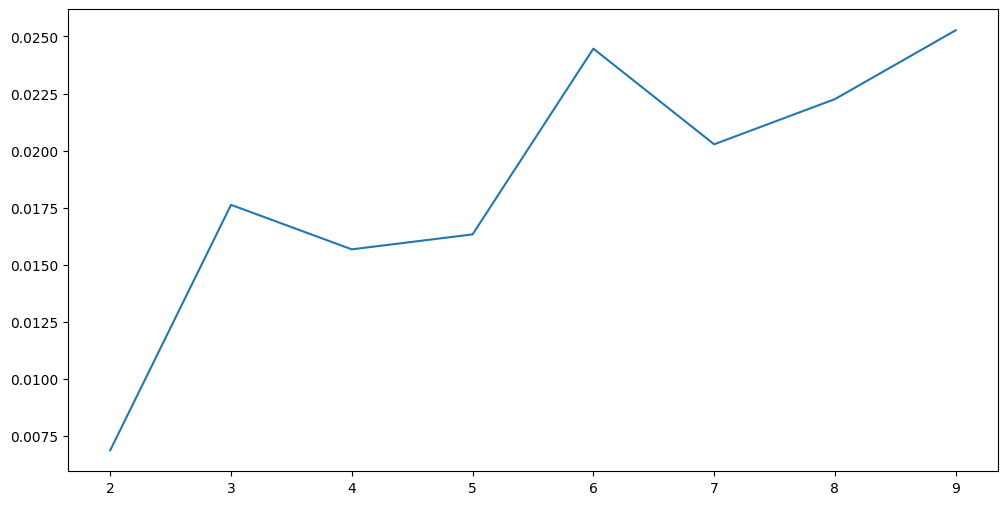

In [73]:
for ii, traj in enumerate(trajs):
    data = znh5md.ASEH5MD(traj)
    atoms = data.get_atoms_list()[slices[ii]]
    determine_n_blocks(atoms)

In [74]:
blocks = [8,7,8,6,7]
means = []
confidences = []
for ii, traj in enumerate(trajs):
    data = znh5md.ASEH5MD(traj)
    atoms = data.get_atoms_list()[slices[ii]]
    mean, std_mean = block_average(atoms, blocks[ii])
    means.append(mean)
    confidences.append(k_95[blocks[ii]]*std_mean)


In [76]:
means

[1.133905525289754,
 0.9869364979504661,
 0.9984668065286726,
 1.181070587144488,
 0.5731028077060298]

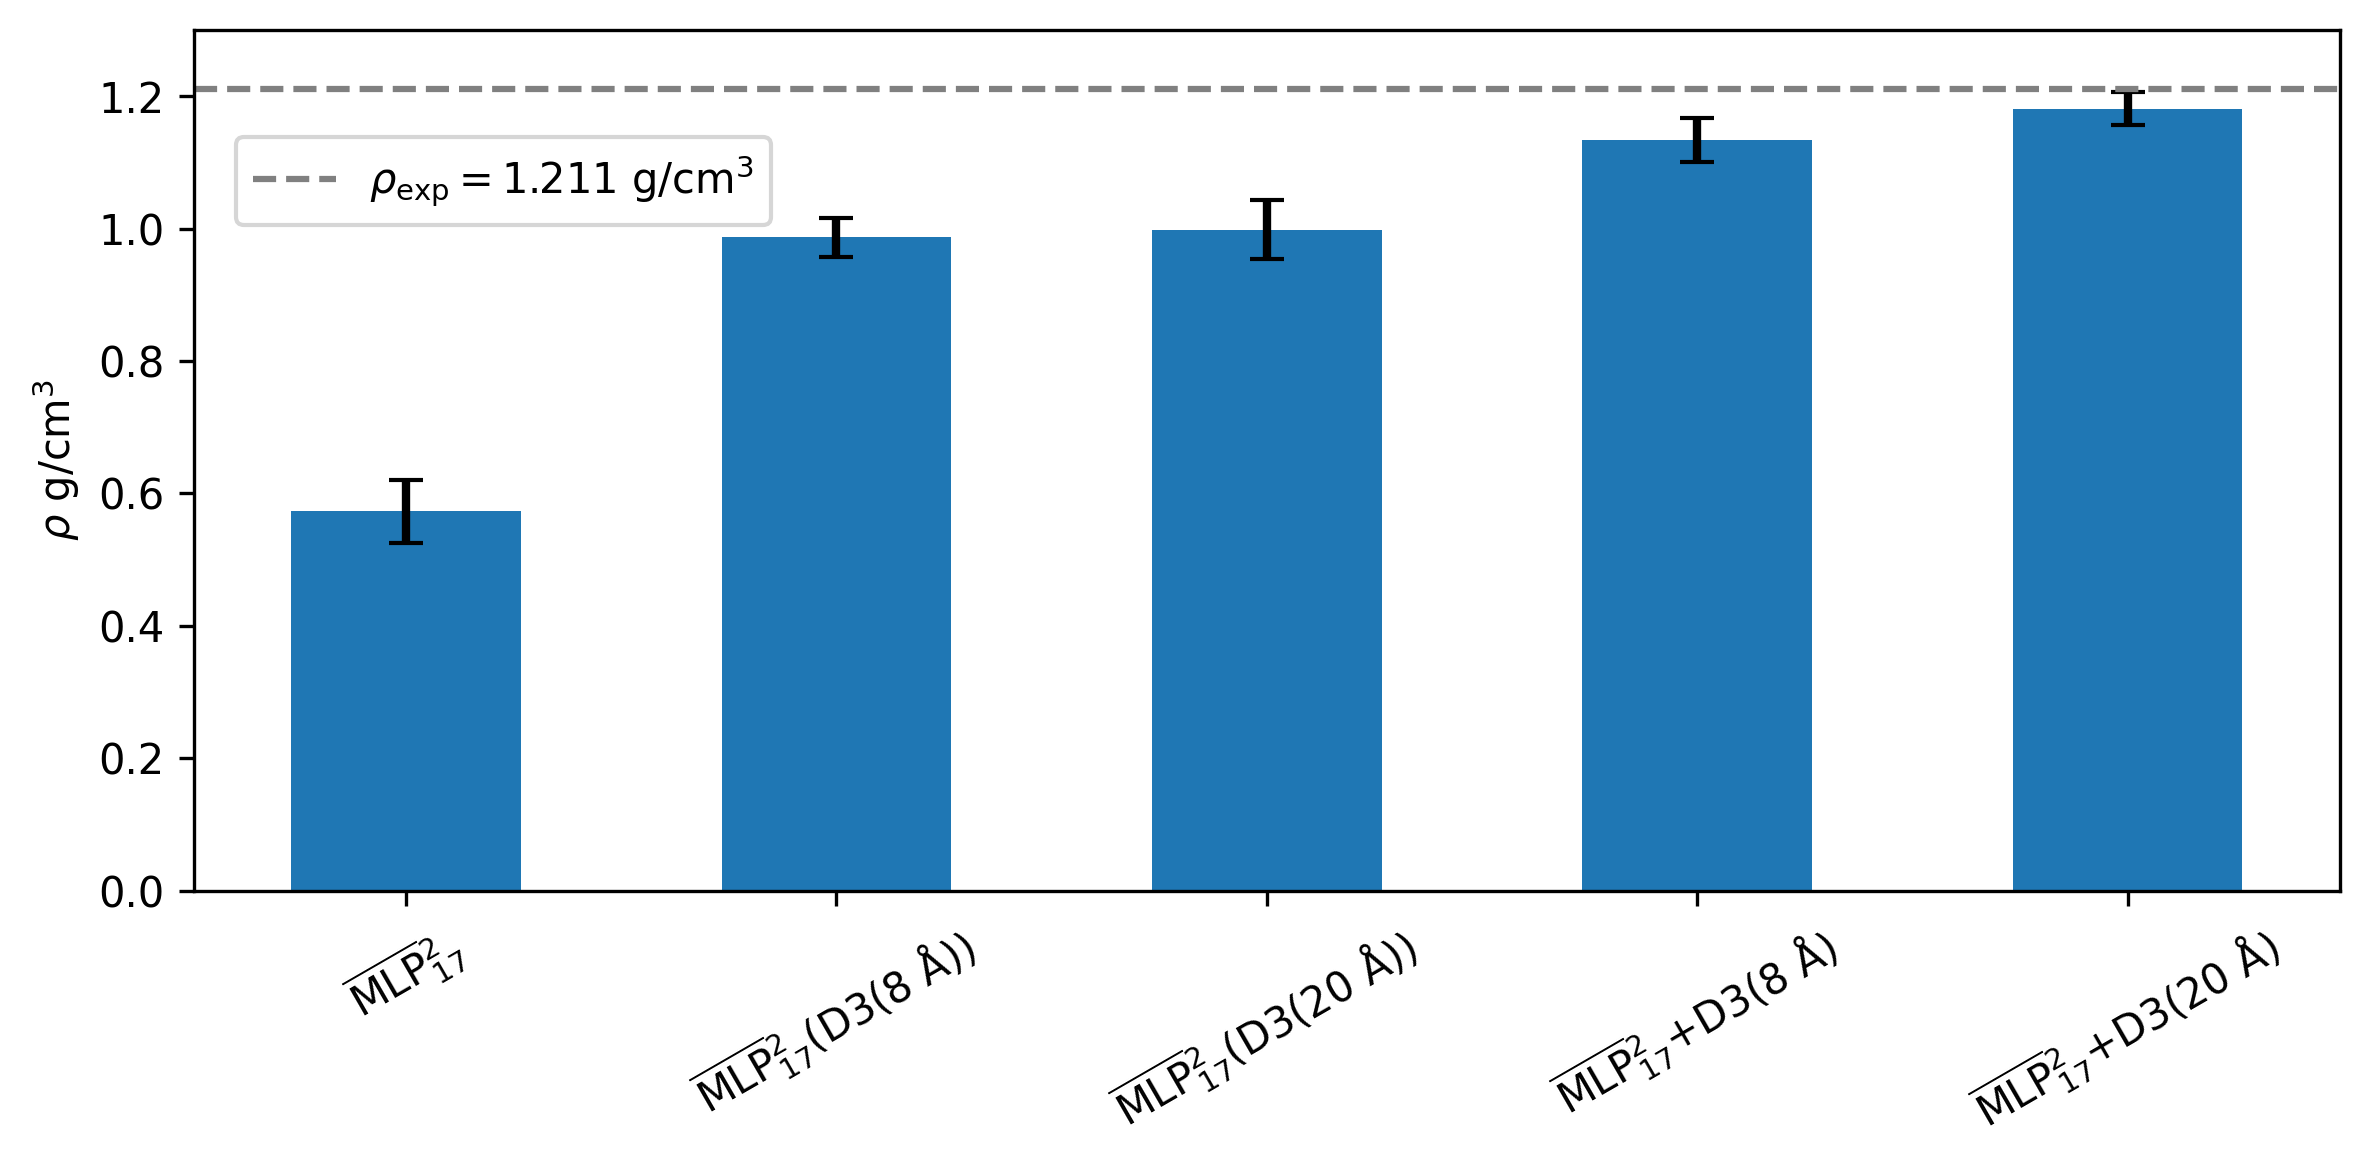

In [86]:

labels = [i*1.5 for i in range(5)]
rho_models_sorted = [
    means[-1],
    means[1],
    means[2],
    means[0],
    means[3],
] # bring in order
err_models_sorted = [
    confidences[-1],
    confidences[1],
    confidences[2],
    confidences[0],
    confidences[3],
]

names = [
    r"$\overline{\text{MLP}}^2_{17}$",
    r"$\overline{\text{MLP}}^2_{17}$(D3(8 Å))",
    r"$\overline{\text{MLP}}^2_{17}$(D3(20 Å))",
    r"$\overline{\text{MLP}}^2_{17}$+D3(8 Å)",
    r"$\overline{\text{MLP}}^2_{17}$+D3(20 Å)"
]

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=300)
ax.bar(labels, rho_models_sorted)
ax.errorbar(labels, rho_models_sorted, err_models_sorted, 0.0, "None", ecolor="black", capsize=4.0, elinewidth=2)
ax.axhline(1.211, linestyle="--", color="gray", label=r"$\rho_{\text{exp}}=1.211$ g/cm$^3$")
ax.set_ylim([0.0,1.300])
# ax.set_xlabel("T / K")
ax.set_ylabel(r"$\rho$ g/cm$^3$")

ax.set_xticks(labels)
ax.set_xticklabels(names, rotation=30)#, ha="right")


ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))
plt.tight_layout()
plt.savefig(f"plots/density_models.png", dpi=300)

## Model SHORT

In [4]:
trajs = [
    "nodes/ML17_density_model_short/ASEMD_1/trajectory.h5",   # 353 
    "nodes/ML17_density_model_short/ASEMD_3/trajectory.h5",   # 333
    "nodes/ML17_density_model_short/ASEMD_5/trajectory.h5",   # 313
    "nodes/ML17_density_model_short/ASEMD_7/trajectory.h5",   # 293
    "nodes/ML17_density_models/ASEMD_2/trajectory.h5",        # 283
]
rho_exps = [
    1162,
    1176,
    1190,
    1204,
    1211,
]
temps = [
    353,
    333,
    313,
    293,
    283,
]

In [ ]:
prefix = ["model (short)" for t in temps]
for pref, T, traj, rho in zip(prefix, temps, trajs, rho_exps):
    analyse(traj, T, pref, rho)

In [49]:
slices = [slice(2500,-1), slice(2500,-1), slice(2000,-1), slice(2500, -1), slice(2500, -1)]
    
rho_model_short, rho_std_model_short = get_density(trajs, slices)

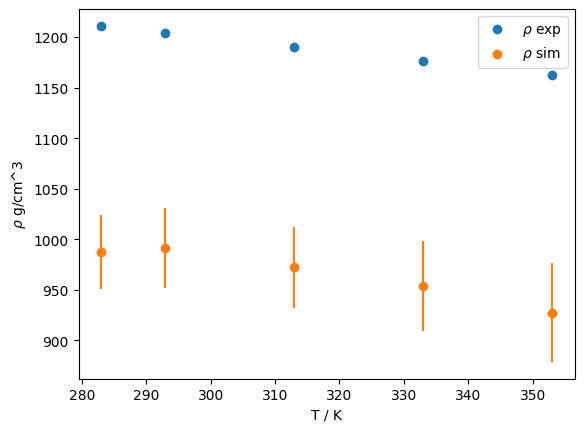

In [50]:
fig, ax = plt.subplots(1,1)
ax.scatter(temps, rho_exps, label=r"$\rho$ exp")
ax.errorbar(temps, rho_model_short, rho_std_model_short, 0.0, "None", ecolor="C1")
ax.scatter(temps, rho_model_short, label=r"$\rho$ sim")
# ax.set_ylim([0.4,1.3])
ax.set_xlabel("T / K")
ax.set_ylabel(r"$\rho$ g/cm^3")
ax.legend()
# plt.savefig(f"plots/rho_v_t.png")

## TD3 SHORT

In [51]:
trajs = [
    "nodes/ML17_density_td3_short/ASEMD_2/trajectory.h5",   # 353 
    "nodes/ML17_density_td3_short/ASEMD_5/trajectory.h5",   # 333
    "nodes/ML17_density_td3_short/ASEMD_8/trajectory.h5",   # 313
    "nodes/ML17_density_td3_short/ASEMD_11/trajectory.h5",   # 293
    "nodes/ML17_density_models/ASEMD_1/trajectory.h5",        # 283
]
rho_exps = [
    1162,
    1176,
    1190,
    1204,
    1211,
]
temps = [
    353,
    333,
    313,
    293,
    283,
]

In [ ]:
prefix = ["TD3(short)" for t in temps]
for pref, T, traj, rho in zip(prefix, temps, trajs, rho_exps):
    analyse(traj, T, pref, rho)

In [52]:
slices = [slice(1000,-1), slice(2000,-1), slice(1800,-1), slice(2000, -1), slice(2000, 17500)]
    
rho_d3_short, rho_std_d3_short = get_density(trajs, slices)

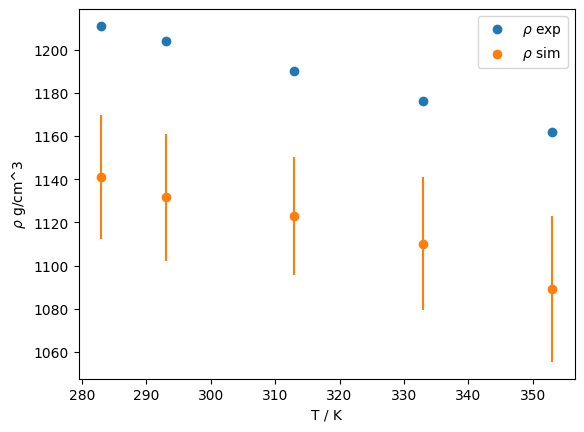

In [53]:
fig, ax = plt.subplots(1,1)
ax.scatter(temps, rho_exps, label=r"$\rho$ exp")
ax.errorbar(temps, rho_d3_short, rho_std_d3_short, 0.0, "None", ecolor="C1")
ax.scatter(temps, rho_d3_short, label=r"$\rho$ sim")
# ax.set_ylim([0.4,1.3])
ax.set_xlabel("T / K")
ax.set_ylabel(r"$\rho$ g/cm^3")
ax.legend()
# plt.savefig(f"plots/rho_v_t.png")

## TD3 LONG

In [54]:
trajs = [
    "nodes/ML17_density_td3_long/ASEMD_2/trajectory.h5",   # 353 
    "nodes/ML17_density_td3_long/ASEMD_5/trajectory.h5",   # 333
    "nodes/ML17_density_td3_long/ASEMD_8/trajectory.h5",   # 313
    "nodes/ML17_density_td3_long/ASEMD_11/trajectory.h5",   # 293
    "nodes/ML17_density_models/ASEMD_5/trajectory.h5",        # 283
]
rho_exps = [
    1162,
    1176,
    1190,
    1204,
    1211,
]
temps = [
    353,
    333,
    313,
    293,
    283,
]

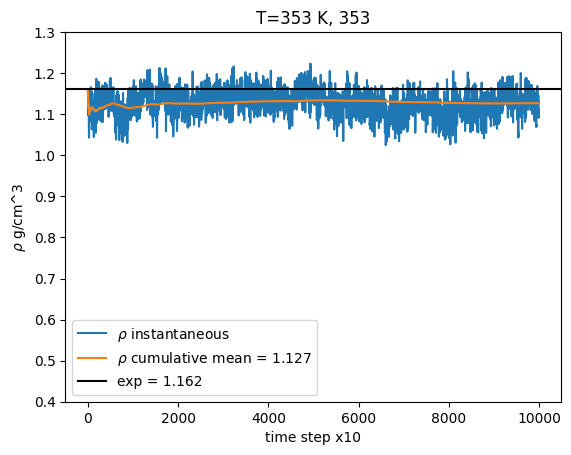

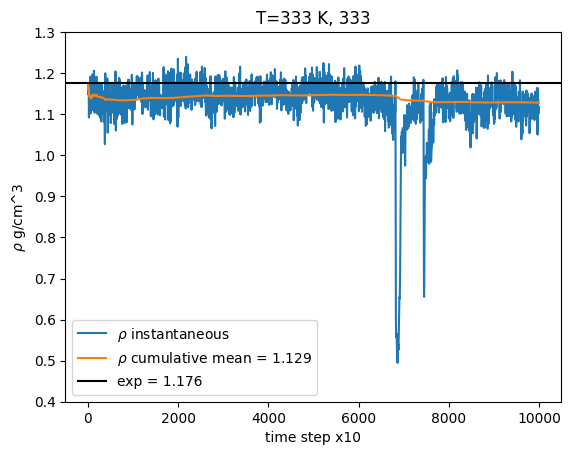

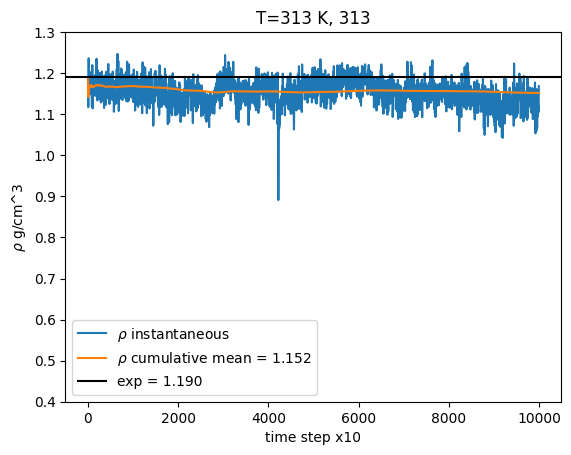

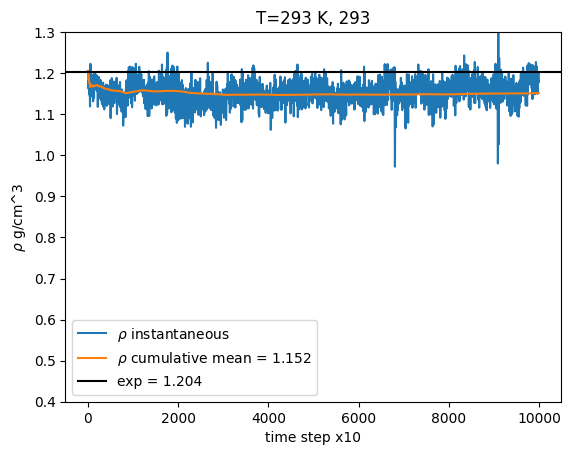

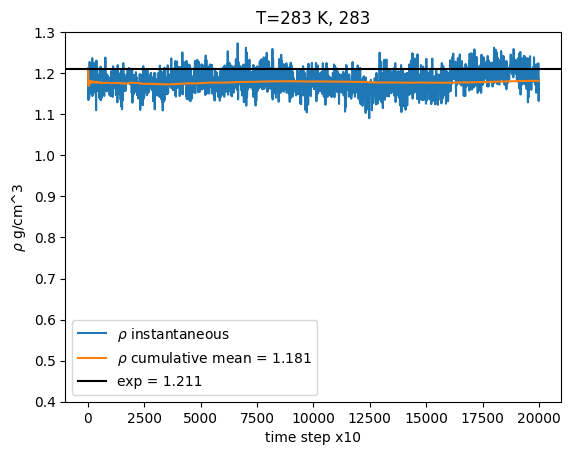

In [4]:
prefix = [str(t) for t in temps]
for pref, T, traj, rho in zip(prefix, temps, trajs, rho_exps):
    analyse(traj, T, pref, rho)

In [55]:
slices = [slice(1600,-1), slice(2100,6000), slice(1000,-1), slice(1600, -1), slice(1000, -1)]
    
rho_d3_long, rho_std_d3_long = get_density(trajs, slices)

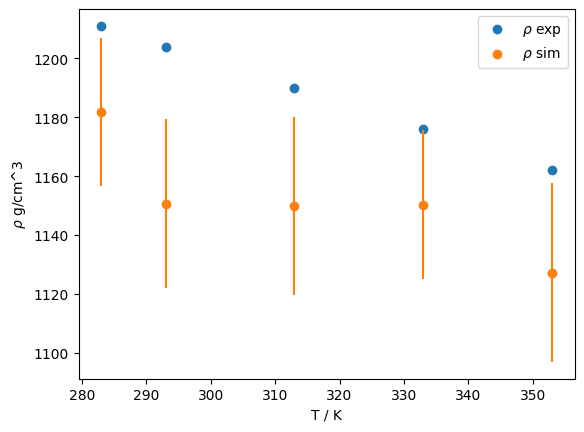

In [57]:
fig, ax = plt.subplots(1,1)
ax.scatter(temps, rho_exps, label=r"$\rho$ exp")
ax.errorbar(temps, rho_d3_long, rho_std_d3_long, 0.0, "None", ecolor="C1")
ax.scatter(temps, rho_d3_long, label=r"$\rho$ sim")
# ax.set_ylim([0.4,1.3])
ax.set_xlabel("T / K")
ax.set_ylabel(r"$\rho$ g/cm^3")
ax.legend()
# plt.savefig(f"plots/rho_v_t.png")

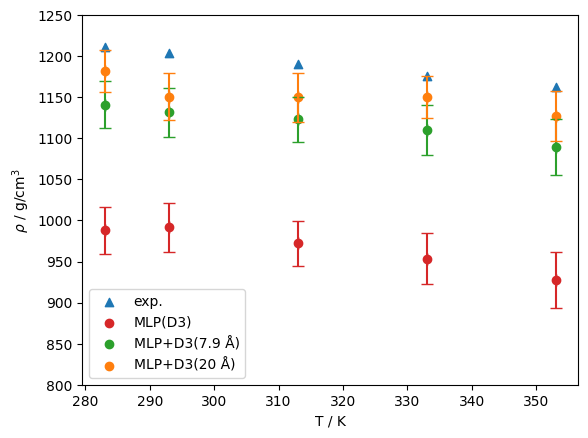

In [91]:
# [353,348,343,338,333,328,323,318,313,308,303,298,293,288,283,]
# all_exp_rhop = [1162,1165,1169,1172,1176,1179,1183,1186,1190,1193,1197,1200,1204,1207,1211]

fig, ax = plt.subplots(1,1)
ax.scatter(temps, rho_exps, marker="^", label=r"exp.")

ax.errorbar(temps, rho_model_short, rho_std_d3_short, 0.0, "None", capsize=4.0, ecolor="C3")
ax.scatter(temps, rho_model_short, c="C3", label=r"MLP(D3)")

ax.errorbar(temps, rho_d3_short, rho_std_d3_short, 0.0, "None", capsize=4.0, ecolor="C2")
ax.scatter(temps, rho_d3_short, c="C2", label=r"MLP+D3(7.9 Å)")

ax.errorbar(temps, rho_d3_long, rho_std_d3_long, 0.0, "None", capsize=4.0, ecolor="C1")
ax.scatter(temps, rho_d3_long, c="C1", label=r"MLP+D3(20 Å)")

ax.set_ylim([800,1250])
ax.set_xlabel("T / K")
ax.set_ylabel(r"$\rho$ / g/cm$^3$")
ax.legend()
# plt.savefig(f"plots/rho_v_t.png", dpi=300)